# **Задание 1. Дискретная марковская цепь**

**Условие:** у нас три состояния $S = {0, 1, 2}$ и на каждом шаге из состояния $i$ мы с вероятностью $1 - \beta$ остаемся в том эе состоянии, а с вероятностью $\beta = 0.1$ переходим равновероятно в любое другое состояние

**1. Построение переходной матрицы $P$**

Для трех состояний матрица $P$ имеет размер $3 \times 3$. Элемент $P_{ij} = q(x_i = j | x_{t1} = 1)$.

- Если $i = j$, то:
$$P_{ij} = 1 - \beta = 0.9$$

- Если $i \ne j$, то из $i$ перейти в любую из двух других состояний с общей вероятностью $\beta$, то есть

$$P_{ij} = \frac{\beta}{2} = \frac{0.1}{2} = 0.05$$

Следовательно:

$$ P =
\left(
\begin{matrix}  
0.9 & 0.05 & 0.05\\  
0.05 & 0.9 & 0.05 \\
0.05 & 0.05 & 0.9 
\end{matrix}
\right)$$ 

**2. Нахожждение станционарного распределения $\pi$**

Станционарное распределение $\pi = (\pi_0, \pi_1, \pi_2)$ удовлетворяет

$$\pi = \pi P,   \sum_{i=0}^2\pi_i = 1.$$


То есть система уровнений:

$$
\begin{cases}  
    \pi_0 = 0.9\pi_0 + 0.05\pi_1 + 0.05\pi_2 \\  
    \pi_0 = 0.05\pi_0 + 0.9\pi_1 + 0.05\pi_2 \\  
    \pi_0 = 0.05\pi_0 + 0.05\pi_1 + 0.9\pi_2 \\  
    \pi_0 + \pi_1 + \pi_2 = 1  
\end{cases}  
$$

Из симметрии видно, что $\pi_0 = \pi_1 = \pi_2$. Тогда

$$3\pi_0 = 1  =>  \pi_0 = \frac{1}{3}$$

Итак,

$$\pi = \left(\frac{1}{3},\frac{1}{3},\frac{1}{3}\right)$$



---------------------------------
**Выводы:**
- Переходная матрица

$$ P =
\left(
\begin{matrix}  
0.9 & 0.05 & 0.05\\  
0.05 & 0.9 & 0.05 \\
0.05 & 0.05 & 0.9 
\end{matrix}
\right)$$ 

- Станционарное распределение

$$\pi = \left(\frac{1}{3},\frac{1}{3},\frac{1}{3}\right)$$

# **Задание 2: Прямая диффузия на MNIST**

**Цель:** 
Научиться **добавлять шум к изображениям** шаг за шагом, чтобы симулировать *forward process* в DDPM

**DDPM (Denoising Diffusion Probalistic Model)** - это тип генеративной модели предложенной в статье [Ho et al., 2020](https://arxiv.org/abs/2006.11239), которая учится **генерировать данные (например изображения) из случайного шума**, проходя через серию обученных шагов по "отшумлению"

**1. Прямая диффузия (forward process):**

Мы берем изображение $x_0$ и пошагово добавляем к нему шум, пока оно не превратится в чистый гауссовский шум:

$$x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow ... \rightarrow x_T \approx N(0, I)$$

Каждый шаг описывается распределением:

$$q(x_t|x_{t-1}) = N(\sqrt{1-\beta_t}x_t-1, \beta_tI$$

**2. Обратный процесс (reverse process):**

Мы хотим научиться делать все наоборот: начиная с шума, шаг за шагом восстанавливать чистое изображение. Это тоже Марковский процесс, но направленный назад:

$$p_\theta(x_{t-1}|x_t)$$

где параметр $\theta$ - веса нейросети, предсказывающей шум

**Что делает DDPM?**

| Шаг | Что происходит | Комментарий |
|-----|----------------|-------------|
| 1   | Добавляем шум к реальным данным (обучение) | Используем известную формулу |
| 2   | Обучаем нейросеть предсказывать добавленный шум | Loss = MSE между предсказанным и настоящим шумом |
| 3   | Генерируем изображение начиная с шума | Применяем обратный процесс |


In [15]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [16]:
def q_sample(x0, t, betas):
    '''
    Добавление шума к изображению x0 на шаге t
        Args:
            - x0: [batch_size, C, H, W] - исходное изображение
            - t: [batch_size] или scalar - текущий шаг
            - betas: тензор [T] - шумовые коэффициенты
    '''
    alpha = 1.0 - betas
    alpha_cumprod = torch.cumprod(alpha, dim=0)     # [T]

    # Берём sqrt(alpha_cumprod[t]) и sqrt(1 - alpha_cumprod[t])
    sqrt_alpha_bar = alpha_cumprod[t] ** 0.5
    sqrt_one_alpha_bar = (1 - alpha_cumprod[t]) ** 0.5

    # Шум
    noise = torch.rand_like(x0)

    # Изображение с добавленным шумом
    return (
        sqrt_alpha_bar.view(-1, 1, 1, 1) * x0 +
        sqrt_one_alpha_bar.view(-1, 1, 1, 1) * noise
    )


In [17]:
# Преобразования: перевод в тензор и нормализация в [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)  # [0,1] → [-1,1]
])

# MNIST dataset
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# DataLoader
loader = DataLoader(mnist, batch_size=64, shuffle=True)

# Получим один батч изображений
x0, _ = next(iter(loader))  # x0.shape = [64, 1, 28, 28]


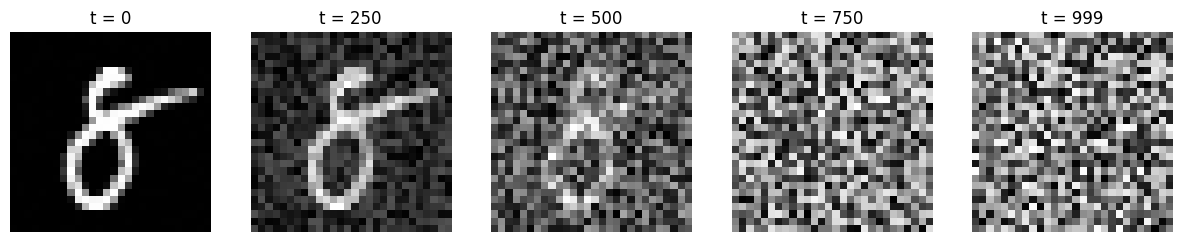

In [19]:
T = 1000  # кол-во шагов
betas = torch.linspace(1e-4, 0.02, T)  # часто используется такая линейная шкала
batch_size = x0.shape[0]

timesteps = [0, T//4, T//2, 3*T//4, T-1]
noisy_imgs = [q_sample(x0, torch.full((batch_size,), t, dtype=torch.long), betas) for t in timesteps]

# Визуализация
fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
for i, img in enumerate(noisy_imgs):
    axes[i].imshow(img[0][0].cpu().detach(), cmap='gray')
    axes[i].set_title(f"t = {timesteps[i]}")
    axes[i].axis('off')
plt.show()


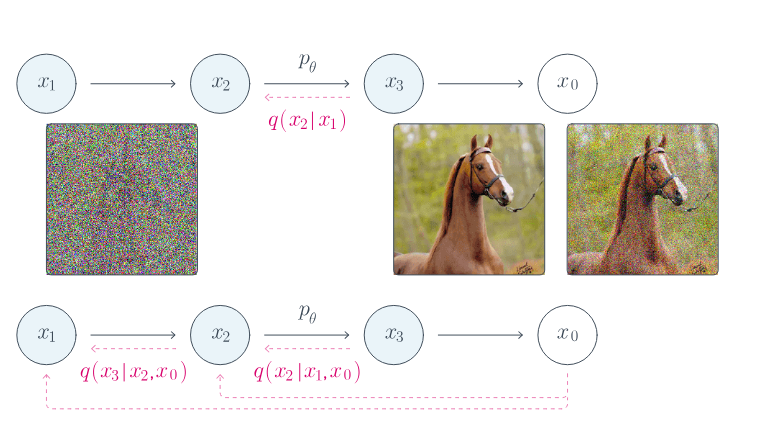

# **Задание 3: Вывод распределения $q(x_t | x_0)$**